In [163]:
import pandas as pd

def check_fact_check_sources(input_csv, output_csv):
    try:
        df = pd.read_csv(input_csv)
    except Exception as e:
        print(f"Failed to read input CSV '{input_csv}': {e}")
        return
    print(df.head(1))
    if 'fact_check_sources' not in df.columns or 'claim_factcheck_url' not in df.columns:
        print("Input CSV must contain 'fact_check_sources' and 'claim_factcheck_url' columns.")
        return

    no_sources = df[df['fact_check_sources'].apply(lambda x: len(eval(x)) == 0)]['claim_factcheck_url']
    if not no_sources.empty:
        no_sources.to_csv(output_csv, index=False, header=['URL'])
        print(f"URLs with no fact_check_sources have been saved to '{output_csv}'")
    else:
        print("All records have fact_check_sources.")

# Define input and output CSV file paths
input_csv = "snopes_results.csv"
output_csv = "no_fact_check_sources.csv"

# Run the check
check_fact_check_sources(input_csv, output_csv)


                                               claim  \
0  An image authentically shows an arrest mug sho...   

                                 claim_factcheck_url  claim_author  \
0  https://www.snopes.com/fact-check/gaetz-mug-sh...           NaN   

   claim_source  claim_date factcheck_date  justification  \
0           NaN         NaN     2024-11-13            NaN   

                                  fact_check_sources          issue label  \
0  ['https://www.bradenton.com/news/politics-gove...  U.S. Politics  True   

                                               tags  \
0  ['Dui', 'Mugshot', 'Matt Gaetz', 'Donald Trump']   

                                                text  
0  Following U.S. President-elect Donald Trump's ...  
URLs with no fact_check_sources have been saved to 'no_fact_check_sources.csv'


In [131]:
df = pd.read_csv("snopes_results.csv")

claim_value = df.iloc[1]
print(claim_value)

claim                  Videos that surfaced in fall 2024 accurately r...
claim_factcheck_url    https://www.snopes.com/fact-check/jennifer-lop...
claim_author                                                         NaN
claim_source                                                         NaN
claim_date                                                           NaN
factcheck_date                                                2024-11-13
justification                                                        NaN
fact_check_sources                                                    []
issue                                                      Entertainment
label                                                              False
tags                   ['FBI', 'Music', 'Movies', 'YouTube', 'TikTok'...
text                   In the fall of 2024, multiple videos surfaced ...
Name: 1, dtype: object


In [134]:
import pandas as pd

# Read the CSV file
df = pd.read_csv("snopes_results.csv")

# Extract the unique domains from the 'issue' column
unique_issues = df['issue'].unique()

# Create a dictionary to store the count of each issue
issue_counts = {}

# Iterate through the unique issues and count the occurrences in the dataframe
for issue in unique_issues:
    issue_counts[issue] = df[df['issue'] == issue].shape[0]

# Print the count of each issue
for issue, count in issue_counts.items():
    print(f"Issue: {issue}, Count: {count}")


Issue: U.S. Politics, Count: 23
Issue: Entertainment, Count: 964
Issue: Politics, Count: 940
Issue: Education, Count: 16
Issue: Disney, Count: 47
Issue: Science, Count: 186
Issue: History, Count: 187
Issue: News, Count: 213
Issue: Lifestyle, Count: 29
Issue: Food, Count: 57
Issue: Technology, Count: 126
Issue: Sports, Count: 113
Issue: No categories found, Count: 23
Issue: Health, Count: 44
Issue: Nature, Count: 2
Issue: Health and Safety, Count: 2
Issue: Military, Count: 37
Issue: Notes, Count: 1
Issue: World News, Count: 10
Issue: Travel, Count: 42
Issue: Animal Kingdom, Count: 4
Issue: Fauxtography, Count: 172
Issue: Language, Count: 13
Issue: Viral Phenomena, Count: 162
Issue: Politicians, Count: 98
Issue: Business, Count: 90
Issue: Legal Affairs, Count: 31
Issue: Crime, Count: 54
Issue: Parenting, Count: 4
Issue: Glurge Gallery, Count: 4
Issue: Questionable Quotes, Count: 79
Issue: Weather, Count: 1
Issue: Immigration, Count: 8
Issue: Horrors, Count: 6
Issue: Gender Issues, Count:

In [135]:
import pandas as pd

# Read the CSV file
df = pd.read_csv("snopes_results.csv")

# Extract the unique labels from the 'label' column
unique_labels = df['label'].unique()

# Create a dictionary to store the count of each label
label_counts = {}

# Iterate through the unique labels and count the occurrences in the dataframe
for label in unique_labels:
    label_counts[label] = df[df['label'] == label].shape[0]

# Print the count of each label
for label, count in label_counts.items():
    print(f"Label: {label}, Count: {count}")


Label: True, Count: 958
Label: False, Count: 1058
Label: Correct Attribution, Count: 270
Label: Research In Progress, Count: 53
Label: Unfounded, Count: 100
Label: Labeled Satire, Count: 561
Label: Miscaptioned, Count: 301
Label: Originated as Satire, Count: 130
Label: Misattributed, Count: 86
Label: Fake, Count: 274
Label: Unproven, Count: 152
Label: Mostly True, Count: 70
Label: Mixture, Count: 218
Label: Mostly False, Count: 36
Label: Legend, Count: 5
Label: Rating not found, Count: 6
Label: Outdated, Count: 29
Label: Scam, Count: 89
Label: Recall, Count: 6
Label: Legit, Count: 9


In [162]:
import trafilatura
from bs4 import BeautifulSoup
import re
import pandas as pd

# Read the CSV files
results_df = pd.read_csv("snopes_results.csv")
no_sources_df = pd.read_csv("no_fact_check_sources.csv")
error_urls = []

# Iterate through the URLs in no_fact_check_sources.csv
for index, row in no_sources_df.iterrows():
    url = row['URL']
    # Fetch the page content
    page = trafilatura.fetch_url(url)
    if not page:
        continue

# Parse the page with BeautifulSoup
    soup = BeautifulSoup(page, 'html.parser')

    # Extract Source Links
    sources = soup.find("div", id="sources_rows")
    extracted_urls = []
    if sources:
        try:
            csl_entries = sources.find("div", class_="csl-bib-body").find_all("div", class_="csl-entry")
        except AttributeError as e:
            print(f"Error processing URL {url}: {e}")
            error_urls.append(url)
            continue
        url_pattern = re.compile(
            r'(https?://(?:www\.|(?!www))[^\s<>"\'()]+|www\.[^\s<>"\'()]+)'
        )
        for entry in csl_entries:
            text = entry.get_text()
            urls = url_pattern.findall(text)
            cleaned_urls = [url.rstrip('.,;') for url in urls]
            extracted_urls.extend(cleaned_urls)

    mask = results_df['claim_factcheck_url'] == url
    row_index = results_df.index[mask][0]
    results_df.at[row_index, 'fact_check_sources'] = extracted_urls




results_df.to_csv("snopes_results.csv", index=False)

Error processing URL https://www.snopes.com/fact-check/trudeau-castro/: 'NoneType' object has no attribute 'find_all'
Error processing URL https://www.snopes.com/fact-check/tag-touch-and-go/: 'NoneType' object has no attribute 'find_all'
Error processing URL https://www.snopes.com/fact-check/trump-bleach-covid-19/: 'NoneType' object has no attribute 'find_all'
Error processing URL https://www.snopes.com/fact-check/klanbake-kkk-march-1924-dnc/: 'NoneType' object has no attribute 'find_all'
Error processing URL https://www.snopes.com/fact-check/trump-inject-bleach-covid-19/: 'NoneType' object has no attribute 'find_all'
Error processing URL https://www.snopes.com/fact-check/trump-salute-north-korean-general-2018/: 'NoneType' object has no attribute 'find_all'
Error processing URL https://www.snopes.com/fact-check/trumps-grandfather-deported/: 'NoneType' object has no attribute 'find_all'
Error processing URL https://www.snopes.com/fact-check/soursop-cancer-cure/: 'NoneType' object has no

In [2]:
# Read the CSV file
import pandas as pd
snopes_results_df = pd.read_csv("snopes_results.csv")

# Get the count of elements
element_count = snopes_results_df.size

# Print the count of elements
print(f"The count of elements in snopes_results.csv is: {element_count}")


The count of elements in snopes_results.csv is: 52932


In [25]:
from bs4 import BeautifulSoup
import re
import trafilatura
df = pd.read_csv("snopes_urls.csv")
url = df.iloc[0].get('URL')
print(url)
page = trafilatura.fetch_url(url)


soup = BeautifulSoup(page, 'html.parser')
sources = soup.find("div", id="sources_rows")
extracted_urls = []
url_pattern = re.compile(
                r'(https?://(?:www\.|(?!www))[^\s<>"\'()]+|www\.[^\s<>"\'()]+)'
            )
p_tags = sources.find_all('p')
for p in p_tags:
    text = p.get_text()
    urls = url_pattern.findall(text)
    cleaned_urls = [url.rstrip('.,;') for url in urls]
    extracted_urls.extend(cleaned_urls)

if len(extracted_urls) == 0:
    csl_entries = sources.find("div", class_="csl-bib-body").find_all("div", class_="csl-entry")
    for entry in csl_entries:
        text = entry.get_text()
        urls = url_pattern.findall(text)
        cleaned_urls = [url.rstrip('.,;') for url in urls]
        extracted_urls.extend(cleaned_urls)

print(extracted_urls)



https://www.snopes.com/fact-check/jennifer-lopez-fled-us-diddy-threat/
['https://www.youtube.com/watch?v=hpZUh_U-q64', 'https://www.youtube.com/watch?v=hpZUh_U-q64', 'https://www.youtube.com/watch?v=oMSFidOa4Dg', 'https://www.youtube.com/watch?v=_Fp7_wBprCE', 'https://www.youtube.com/watch?v=0vy7-sN8mw0', 'https://www.youtube.com/watch?v=9jLsHs9igGQ', 'https://www.youtube.com/watch?v=uamDOngRf4Y', 'https://www.youtube.com/watch?v=Xf6m4NJVxKE', 'https://www.youtube.com/watch?v=s-WL9ZWWMwI', 'https://www.fbi.gov/history/directors/christopher-wray', 'www.facebook.com', 'https://www.facebook.com/100090647973111/videos/fbi-reveals-jennifer-lopez-escapes-the-country-after-diddys-threat/535674845674700/', 'https://www.elle.com.au/culture/jennifer-lopez-sean-p-diddy-combs/', 'https://www.instagram.com/accounts/login/?next=https%3A%2F%2Fwww.instagram.com%2Fjlo%2F&is_from_rle', 'https://people.com/jennifer-lopez-and-emme-are-all-smiles-at-wicked-premiere-8743384', 'https://wwd.com/pop-culture/ce

In [31]:
import pandas as pd

# Read the file ignoring problematic lines first to see what we're dealing with
try:
    # Try reading with error handling
    df = pd.read_csv("snopes_results.csv", on_bad_lines='warn', encoding='utf-8', quoting=1)
except Exception as e:
    # If that fails, try reading with more permissive settings
    df = pd.read_csv("snopes_results.csv", 
                     on_bad_lines='skip',  # Skip bad lines
                     encoding='utf-8',
                     quoting=1,
                     dtype=str) 

/var/folders/0t/x68mqnvj07z7cddrmkc67qz80000gn/T/ipykernel_79899/1587786523.py:6: ParserWarning: Skipping line 12: expected 12 fields, saw 13
Skipping line 13: expected 12 fields, saw 13
Skipping line 14: expected 12 fields, saw 13
Skipping line 15: expected 12 fields, saw 13
Skipping line 16: expected 12 fields, saw 13
Skipping line 17: expected 12 fields, saw 13
Skipping line 18: expected 12 fields, saw 13
Skipping line 19: expected 12 fields, saw 13
Skipping line 20: expected 12 fields, saw 13
Skipping line 21: expected 12 fields, saw 13
Skipping line 72: expected 12 fields, saw 13
Skipping line 73: expected 12 fields, saw 13
Skipping line 74: expected 12 fields, saw 13
Skipping line 75: expected 12 fields, saw 13
Skipping line 76: expected 12 fields, saw 13
Skipping line 77: expected 12 fields, saw 13
Skipping line 78: expected 12 fields, saw 13
Skipping line 79: expected 12 fields, saw 13
Skipping line 80: expected 12 fields, saw 13
Skipping line 81: expected 12 fields, saw 13
Ski

In [35]:
import pandas as pd
import csv

def inspect_csv_file(filename):
    # First, let's read the file as raw text to count fields in each row
    with open(filename, 'r', encoding='utf-8') as file:
        csv_reader = csv.reader(file)
        headers = next(csv_reader)  # Skip header row
        print(f"Number of header columns: {len(headers)}")
        print("\nHeaders:", headers)
        
        print("\nProblematic rows:")
        for line_num, row in enumerate(csv_reader, start=2):  # Start at 2 because we skipped header
            if len(row) != len(headers):
                print(f"\nLine {line_num} has {len(row)} fields (expected {len(headers)}):")
                print("Fields:", row)
                print("Extra or missing fields:", abs(len(row) - len(headers)))
                
                # Print each field with its index to help identify where the problem is
                print("\nDetailed field breakdown:")
                for i, field in enumerate(row):
                    print(f"Field {i}: {field[:100]}...")
                    # Print first 100 chars of each field
                break

inspect_csv_file("snopes_results.csv")

Number of header columns: 12

Headers: ['claim', 'claim_factcheck_url', 'claim_author', 'claim_source', 'claim_date', 'factcheck_date', 'justification', 'fact_check_sources', 'issue', 'label', 'tags', 'text']

Problematic rows:

Line 12 has 13 fields (expected 12):
Fields: ["A video authentically shows a mother entering a classroom in a U.S. public school and taking down a teacher's Progress Pride Flag that was covering a map of the U.S.", 'https://www.snopes.com/fact-check/mother-pride-flag-classroom/', '', '', '', '2024-11-12', '', "['https://help.twitter.com/en/using-x/community-notes', 'https://apnews.com/6434ade5c34f447db585304666d6478f', 'https://www.facebook.com/Kenyonsfriends/', 'https://www.hrc.org/resources/lgbtq-pride-flags', 'https://twitter.com/i/birdwatch/t/1703875499788034189', 'https://factcheck.afp.com/doc.afp.com.33VL6VA']", 'Education', 'Miscaptioned', "['LGBTQ']", 'A rumor circulating online in late 2024 claimed a video showed a mother walking into a U.S. classroom 

In [37]:
import pandas as pd
import csv

def remove_extra_column(filename, output_filename):
    # Read the file and remove the 13th column from problematic rows
    with open(filename, 'r', encoding='utf-8') as infile, open(output_filename, 'w', encoding='utf-8', newline='') as outfile:
        csv_reader = csv.reader(infile)
        csv_writer = csv.writer(outfile)
        
        headers = next(csv_reader)
        csv_writer.writerow(headers)  # Write headers to the output file
        
        for row in csv_reader:
            if len(row) == 13:
                row.pop(12)  # Remove the 13th column
            csv_writer.writerow(row)

# Apply the function to clean the CSV file
remove_extra_column("snopes_results.csv", "snopes_results_cleaned.csv")

# Read the cleaned file
try:
    df = pd.read_csv("snopes_results_cleaned.csv", on_bad_lines='warn', encoding='utf-8', quoting=1)
except Exception as e:
    df = pd.read_csv("snopes_results_cleaned.csv", 
                     on_bad_lines='skip',  
                     encoding='utf-8',
                     quoting=1,
                     dtype=str) 



label
False                   1463
True                    1228
Labeled Satire           561
Mixture                  218
Unproven                 152
Mostly True               70
Research In Progress      53
Mostly False              36
Name: count, dtype: int64


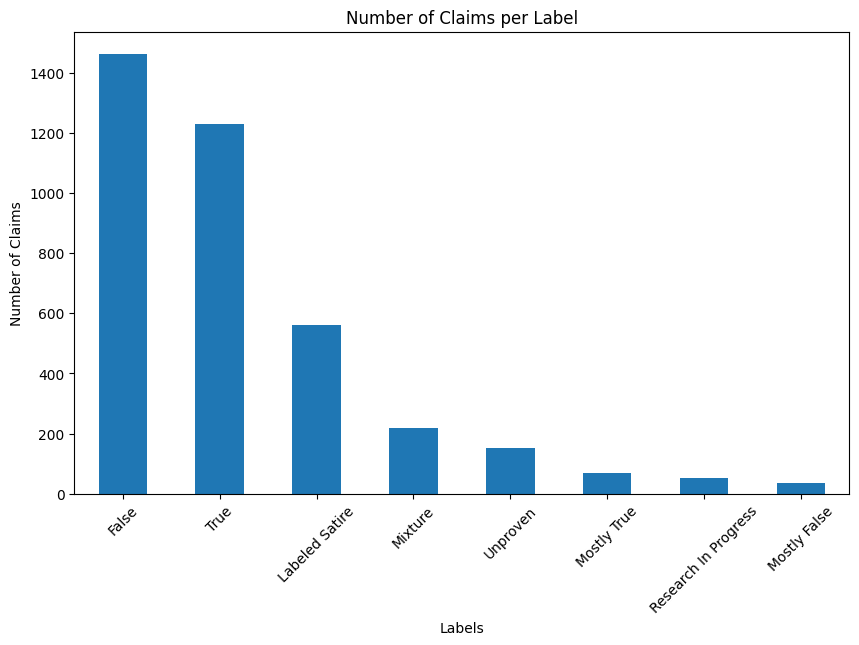

In [53]:
import matplotlib.pyplot as plt

df = pd.read_csv("snopes_results_cleaned.csv", on_bad_lines='warn', encoding='utf-8', quoting=1)
unique_labels = df['label'].unique()

# Count the number of claims per each label
label_counts = df['label'].value_counts()
print(label_counts)
# Plot the graph
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.xlabel('Labels')
plt.ylabel('Number of Claims')
plt.title('Number of Claims per Label')
plt.xticks(rotation=45)
plt.show()


In [45]:
# Remove rows with specific labels
labels_to_remove = ["Fake", "Miscaptioned"]
df = df[~df['label'].isin(labels_to_remove)]

# Save the cleaned DataFrame back to the CSV
df.to_csv("snopes_results_cleaned.csv", index=False)




In [52]:
df['label'] = df['label'].replace("Originated as Satire", "False")
df.to_csv("snopes_results_cleaned.csv", index=False)

